#

# Problem Statement: **Stock Movement Prediction using Spectogram, Technical Indicators and News**

### The code file - named as [insert_name].ipynb

# **Import Libraries**

In [101]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import spectrogram
import pandas as pd

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from torchvision import models
import torch.nn.functional as F

from sklearn.metrics import accuracy_score
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error


# **Loading the Dataset**

In [57]:
folder_path = 'data/new_label_dataset/'

In [58]:
start_date = "2017-01-01"
end_date = "2022-12-31"

In [59]:
stock_symbol = 'AUBANK.NS'

In [60]:
aubank_data = pd.read_csv(f'{folder_path}/{stock_symbol}.csv')

In [61]:
aubank_data.shape

(1322, 30)

In [62]:
aubank_data.head(10)

,Date,Open,High,Low,Close,Adj Close,Volume,SMA_9,SMA_21,EMA_9,...,BB_lower,ADX,ADX+DI,ADX-DI,CMF,OBV,CCI,Williams_%R,ATR,Target
0,2017-08-29,265.500000,279.399994,265.500000,272.399994,270.861786,1649802,268.661109,275.953571,269.747170,...,257.109623,46.315878,15.579860,27.511465,0.182936,-7916212.0,-22.486667,-43.905643,11.294367,0.00
1,2017-08-30,275.000000,278.875000,274.225006,275.424988,273.869659,712294,269.036109,275.057142,270.882733,...,258.701281,44.629755,14.862239,26.244265,0.162639,-7203918.0,24.239067,-22.460356,10.919995,0.53
2,2017-08-31,274.899994,278.225006,273.000000,274.725006,273.173615,580208,269.366665,274.077381,271.651188,...,260.456179,43.268357,14.290231,26.136532,0.141817,-7784126.0,30.892280,-16.461228,10.480352,0.50
3,2017-09-01,275.500000,285.000000,273.774994,276.149994,274.590576,1765988,270.174998,273.277380,272.550949,...,262.568087,40.724434,18.056729,23.999530,0.124248,-6018138.0,96.957914,-36.875025,10.537509,0.51
4,2017-09-04,277.875000,282.149994,271.024994,278.500000,276.927307,1182770,271.108331,272.682142,273.740759,...,262.630387,38.798966,16.607432,24.057285,0.144057,-4835368.0,88.353220,-27.083333,10.582363,0.52
5,2017-09-05,280.049988,288.250000,276.575012,286.575012,284.956726,1989224,273.533332,273.030952,276.307610,...,261.445038,36.017884,19.571585,22.056518,0.186246,-2846144.0,177.568397,-6.146744,10.665375,0.57
6,2017-09-06,284.000000,289.000000,281.799988,283.924988,282.321686,1157354,275.899997,273.353571,277.831085,...,260.914892,33.384987,19.092384,20.902004,0.166896,-4003498.0,160.379632,-18.125044,10.403286,0.48
7,2017-09-07,285.625000,288.000000,277.500000,279.350006,277.772491,815452,277.336110,273.527380,278.134870,...,261.370567,31.613485,17.642099,22.425050,0.090621,-4818950.0,117.262176,-34.464264,10.410570,0.47
8,2017-09-08,280.500000,282.750000,275.000000,277.174988,275.609802,831916,278.247220,273.194047,277.942893,...,261.367084,30.339722,16.637531,22.984957,0.036877,-5650866.0,67.870040,-42.232186,10.210966,0.49
9,2017-09-11,279.375000,282.450012,275.500000,279.299988,277.722839,697004,279.013885,273.401188,278.214312,...,261.489833,29.181880,15.770295,21.786860,0.068276,-4953862.0,69.590690,-34.642901,9.967196,0.52


## **Principal Component Analysis**

In [63]:
features = aubank_data.drop(columns=['Date', 'Target'])

scaler = StandardScaler()
scaled_features = scaler.fit_transform(features)

explained_variance_ratios = []
num_features = range(1, len(features.columns) + 1)

for n in num_features:
    pca = PCA(n_components=n)
    pca.fit(scaled_features)
    explained_variance_ratios.append(sum(pca.explained_variance_ratio_))


Plotting the explained variance ratio

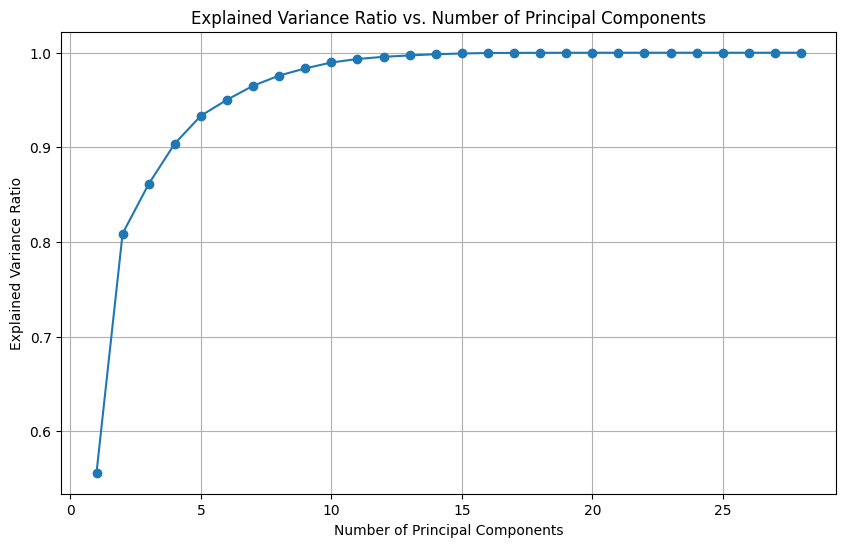

In [64]:
plt.figure(figsize=(10, 6))
plt.plot(num_features, explained_variance_ratios, marker='o')
plt.xlabel('Number of Principal Components')
plt.ylabel('Explained Variance Ratio')
plt.title('Explained Variance Ratio vs. Number of Principal Components')
plt.grid(True)
plt.show()

Performing PCA with the optimal number of components

In [65]:
optimal_components = 13  
pca = PCA(n_components=optimal_components)
principal_components = pca.fit_transform(scaled_features)

pca_df = pd.DataFrame(data=principal_components, columns=[f'PC {i+1}' for i in range(optimal_components)])

pca_df['Date'] = aubank_data['Date']
pca_df['Target'] = aubank_data['Target']

pca_df.head()

,PC 1,PC 2,PC 3,PC 4,PC 5,PC 6,PC 7,PC 8,PC 9,PC 10,PC 11,PC 12,PC 13,Date,Target
0,-4.761518,-0.705379,-0.989621,1.359001,-0.305807,0.465252,-0.390279,-0.834717,-0.367757,0.743379,0.079532,-0.059056,0.103470,2017-08-29,0.00
1,-4.694228,0.083276,-1.162377,0.803311,-0.829710,0.323020,-0.587892,-0.787388,-0.010206,0.961482,0.045206,0.017042,0.068746,2017-08-30,0.53
2,-4.684926,0.433214,-1.281650,0.487922,-0.951935,0.198866,-1.024008,-0.658220,-0.055787,0.891507,0.013281,0.027874,0.036422,2017-08-31,0.50
3,-4.525571,0.787203,-1.380134,0.382077,-0.251228,0.098943,-0.711269,-0.525808,-0.468123,0.170234,0.538297,-0.026149,-0.003017,2017-09-01,0.51
4,-4.511782,0.996872,-1.247951,0.219934,-0.488568,0.243139,-0.885079,-0.491716,-0.241914,0.346426,0.376298,0.015686,-0.054790,2017-09-04,0.52


In [66]:
news_data = pd.read_csv('data/news/news_categorical.csv')
news_data.head()

,Date,Daily_Sentiment,News,Event,Reason,Verdict
0,2018-01-01,Neutral,Odisha turns to banking outlets to cover untap...,8,3,3
1,2018-01-02,Neutral,"Min balance row: SBI breaks silence, says it w...",9,6,2
2,2018-01-03,Neutral,RBI puts Allahabad Bank under prompt correctiv...,9,6,1
3,2018-01-04,Neutral,Rs 200-note recalibration: ATM operators see R...,6,3,1
4,2018-01-05,Neutral,Indian Overseas Bank plans to write off its lo...,10,3,2


# **Combining Datasets**

In [67]:
news_data['Date'] = pd.to_datetime(news_data['Date'])
pca_df['Date'] = pd.to_datetime(pca_df['Date'])

filtered_news_data = news_data[news_data['Date'].isin(pca_df['Date'])]

filtered_news_data.reset_index(drop=True, inplace=True)
filtered_news_data.head()

,Date,Daily_Sentiment,News,Event,Reason,Verdict
0,2018-01-01,Neutral,Odisha turns to banking outlets to cover untap...,8,3,3
1,2018-01-02,Neutral,"Min balance row: SBI breaks silence, says it w...",9,6,2
2,2018-01-03,Neutral,RBI puts Allahabad Bank under prompt correctiv...,9,6,1
3,2018-01-04,Neutral,Rs 200-note recalibration: ATM operators see R...,6,3,1
4,2018-01-05,Neutral,Indian Overseas Bank plans to write off its lo...,10,3,2


Merge pca_df and filtered_news_data on the 'Date' column

In [68]:
combined_df = pd.merge(pca_df, filtered_news_data, on='Date', how='inner')
combined_df.head()

,PC 1,PC 2,PC 3,PC 4,PC 5,PC 6,PC 7,PC 8,PC 9,PC 10,PC 11,PC 12,PC 13,Date,Target,Daily_Sentiment,News,Event,Reason,Verdict
0,-2.982805,-1.978402,2.198418,-0.512346,0.536655,-0.264951,0.432075,0.500445,-0.052044,-0.148288,-0.059669,-0.214988,0.085493,2018-01-01,0.49,Neutral,Odisha turns to banking outlets to cover untap...,8,3,3
1,-3.045867,-2.294321,2.260089,-0.457557,0.568953,-0.299640,0.541198,0.355993,0.078547,-0.088285,-0.001613,-0.138374,0.107065,2018-01-02,0.50,Neutral,"Min balance row: SBI breaks silence, says it w...",9,6,2
2,-3.000151,-1.758818,1.935508,-0.710845,0.420745,-0.390122,0.585726,0.077431,0.530460,0.345852,-0.137150,-0.065042,0.059960,2018-01-03,0.53,Neutral,RBI puts Allahabad Bank under prompt correctiv...,9,6,1
3,-2.935524,-1.151543,1.583807,-0.962817,0.260099,-0.440916,0.388483,-0.044190,0.724762,0.560005,-0.279445,-0.043592,0.021388,2018-01-04,0.52,Neutral,Rs 200-note recalibration: ATM operators see R...,6,3,1
4,-2.585466,0.918231,0.509054,-1.490076,0.221634,-0.349041,0.534168,0.110935,0.987261,0.997636,-0.402921,-0.277577,-0.048661,2018-01-05,0.60,Neutral,Indian Overseas Bank plans to write off its lo...,10,3,2


In [99]:
sentiment_mapping = {
    'Positive': 1,
    'Neutral': 0,
    'Negative': -1
}

combined_df['Sentiment_Label'] = combined_df['Daily_Sentiment'].map(sentiment_mapping)
pca_df = combined_df
pca_df.head()

,PC 1,PC 2,PC 3,PC 4,PC 5,PC 6,PC 7,PC 8,PC 9,PC 10,...,PC 12,PC 13,Date,Target,Daily_Sentiment,News,Event,Reason,Verdict,Sentiment_Label
0,-2.982805,-1.978402,2.198418,-0.512346,0.536655,-0.264951,0.432075,0.500445,-0.052044,-0.148288,...,-0.214988,0.085493,2018-01-01,0.49,Neutral,Odisha turns to banking outlets to cover untap...,8,3,3,0
1,-3.045867,-2.294321,2.260089,-0.457557,0.568953,-0.299640,0.541198,0.355993,0.078547,-0.088285,...,-0.138374,0.107065,2018-01-02,0.50,Neutral,"Min balance row: SBI breaks silence, says it w...",9,6,2,0
2,-3.000151,-1.758818,1.935508,-0.710845,0.420745,-0.390122,0.585726,0.077431,0.530460,0.345852,...,-0.065042,0.059960,2018-01-03,0.53,Neutral,RBI puts Allahabad Bank under prompt correctiv...,9,6,1,0
3,-2.935524,-1.151543,1.583807,-0.962817,0.260099,-0.440916,0.388483,-0.044190,0.724762,0.560005,...,-0.043592,0.021388,2018-01-04,0.52,Neutral,Rs 200-note recalibration: ATM operators see R...,6,3,1,0
4,-2.585466,0.918231,0.509054,-1.490076,0.221634,-0.349041,0.534168,0.110935,0.987261,0.997636,...,-0.277577,-0.048661,2018-01-05,0.60,Neutral,Indian Overseas Bank plans to write off its lo...,10,3,2,0


# **Model**

In [ ]:
X = pca_df.drop(columns=['Date', 'Target', 'Daily_Sentiment','News']).values
y = pca_df['Target'].values

split_index = int(0.8 * len(pca_df))

train_indices = pca_df.index[:split_index]
test_indices = pca_df.index[split_index:]

In [108]:
train_indices

RangeIndex(start=0, stop=462, step=1)

Split the data manually

In [ ]:
X_train = X[:split_index]
X_test = X[split_index:]
y_train = y[:split_index]
y_test = y[split_index:]

Convert the data to PyTorch tensors

In [ ]:
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)

Create DataLoader for training and testing sets

In [ ]:
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Define the LSTM model

In [118]:
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(LSTMModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)
    
    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        
        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])
        return out

# Initialize the model, loss function, and optimizer
input_size = X_train.shape[1]
hidden_size = 50
num_layers = 2
output_size = 1

model = LSTMModel(input_size, hidden_size, num_layers, output_size)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Train the model
num_epochs = 50
for epoch in range(num_epochs):
    model.train()
    for X_batch, y_batch in train_loader:
        X_batch = X_batch.unsqueeze(1)  # Add sequence dimension
        y_batch = y_batch.unsqueeze(1)
        
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

Epoch [1/50], Loss: 0.0825
Epoch [2/50], Loss: 0.0075
Epoch [3/50], Loss: 0.0016
Epoch [4/50], Loss: 0.0013
Epoch [5/50], Loss: 0.0019
Epoch [6/50], Loss: 0.0079
Epoch [7/50], Loss: 0.0011
Epoch [8/50], Loss: 0.0007
Epoch [9/50], Loss: 0.0020
Epoch [10/50], Loss: 0.0010
Epoch [11/50], Loss: 0.0015
Epoch [12/50], Loss: 0.0015
Epoch [13/50], Loss: 0.0009
Epoch [14/50], Loss: 0.0013
Epoch [15/50], Loss: 0.0012
Epoch [16/50], Loss: 0.0012
Epoch [17/50], Loss: 0.0013
Epoch [18/50], Loss: 0.0009
Epoch [19/50], Loss: 0.0005
Epoch [20/50], Loss: 0.0013
Epoch [21/50], Loss: 0.0007
Epoch [22/50], Loss: 0.0007
Epoch [23/50], Loss: 0.0007
Epoch [24/50], Loss: 0.0007
Epoch [25/50], Loss: 0.0005
Epoch [26/50], Loss: 0.0005
Epoch [27/50], Loss: 0.0015
Epoch [28/50], Loss: 0.0020
Epoch [29/50], Loss: 0.0006
Epoch [30/50], Loss: 0.0009
Epoch [31/50], Loss: 0.0005
Epoch [32/50], Loss: 0.0014
Epoch [33/50], Loss: 0.0014
Epoch [34/50], Loss: 0.0013
Epoch [35/50], Loss: 0.0006
Epoch [36/50], Loss: 0.0009
E

In [121]:
# Extract the dates corresponding to the train set using the train_indices
train_labels = y_train
train_predictions = []

model.eval()
with torch.no_grad():
    for X_batch, _ in train_loader:
        X_batch = X_batch.unsqueeze(1)  # Add sequence dimension
        outputs = model(X_batch)
        train_predictions.extend(outputs.squeeze().tolist())

train_predictions = np.array(train_predictions)
train_predictions

train_results_df = pd.DataFrame({
    'Date': pca_df.loc[train_indices, 'Date'].values,
    'Predicted': train_predictions,
    'Actual': y_train
})
train_results_df.head()

# train_dates = pca_df.loc[train_indices, 'Date'].values


,Date,Predicted,Actual
0,2018-01-01,0.511234,0.49
1,2018-01-02,0.486145,0.50
2,2018-01-03,0.496470,0.53
3,2018-01-04,0.534574,0.52
4,2018-01-05,0.497034,0.60


In [122]:
train_results_df.to_csv('./data/new_Data/train_data_sentiment.csv', index=False)

In [ ]:
# Evaluate the model
model.eval()
with torch.no_grad():
    y_pred = []
    y_true = []
    for X_batch, y_batch in test_loader:
        X_batch = X_batch.unsqueeze(1)  # Add sequence dimension
        outputs = model(X_batch)
        y_pred.extend(outputs.squeeze().tolist())
        y_true.extend(y_batch.tolist())

# Calculate accuracy or other metrics as needed
mse = mean_squared_error(y_true, y_pred)
print(f'Mean Squared Error: {mse:.4f}')

In [71]:
# Calculate MAE
mae = mean_absolute_error(y_true, y_pred)
print(f'Mean Absolute Error: {mae:.4f}')

Mean Absolute Error: 0.0605


In [72]:
# Extract the dates corresponding to the test set using the test_indices
test_dates = pca_df.loc[test_indices, 'Date'].values

# Print the date, predicted, and actual values
for date, pred, actual in zip(test_dates, y_pred, y_true):
    print(f"Date: {date}, Predicted: {pred:.4f}, Actual: {actual:.4f}")

Date: 2019-12-04T00:00:00.000000000, Predicted: 0.4493, Actual: 0.5100
Date: 2019-12-05T00:00:00.000000000, Predicted: 0.4773, Actual: 0.4900
Date: 2019-12-06T00:00:00.000000000, Predicted: 0.5068, Actual: 0.5000
Date: 2019-12-09T00:00:00.000000000, Predicted: 0.5113, Actual: 0.5000
Date: 2019-12-10T00:00:00.000000000, Predicted: 0.5383, Actual: 0.4700
Date: 2019-12-11T00:00:00.000000000, Predicted: 0.5315, Actual: 0.5100
Date: 2019-12-12T00:00:00.000000000, Predicted: 0.5242, Actual: 0.5000
Date: 2019-12-13T00:00:00.000000000, Predicted: 0.5144, Actual: 0.4900
Date: 2019-12-16T00:00:00.000000000, Predicted: 0.5209, Actual: 0.5000
Date: 2019-12-17T00:00:00.000000000, Predicted: 0.5134, Actual: 0.5100
Date: 2019-12-18T00:00:00.000000000, Predicted: 0.5173, Actual: 0.4900
Date: 2019-12-19T00:00:00.000000000, Predicted: 0.5246, Actual: 0.5000
Date: 2019-12-20T00:00:00.000000000, Predicted: 0.5226, Actual: 0.5100
Date: 2019-12-23T00:00:00.000000000, Predicted: 0.5150, Actual: 0.4800
Date: 

In [113]:
# Extract the dates corresponding to the test set
test_dates = pca_df.loc[test_indices, 'Date'].values

# Create a DataFrame with Date, Predicted, and Actual columns
results_df = pd.DataFrame({
    'Date': test_dates,
    'Predicted': y_pred,
    'Actual': y_true
})
results_df

# Save the results to a CSV file
results_df.to_csv('./data/new_Data/test_data_sentiment.csv', index=False)


In [74]:
folder_path = 'data/new_label_dataset/'

In [75]:
bank_nifty_stock_symbols = [
    "HDFCBANK.NS",
    "AXISBANK.NS",
    "ICICIBANK.NS",
    "HDFCBANK.NS",
    "KOTAKBANK.NS",
    "SBIN.NS",
    "INDUSINDBK.NS",
    "BANDHANBNK.NS",
    "FEDERALBNK.NS",
    "PNB.NS",
    "IDFCFIRSTB.NS",
    "BANKBARODA.NS",
    "AUBANK.NS"
]

In [76]:
def get_stock_maximums(folder_path):
    stock_maximums = {}

    for stock_symbol in bank_nifty_stock_symbols:
        stock_df = pd.read_csv(f"{folder_path}{stock_symbol}.csv")
        maximum_rise_in_price_in_consecutive_days = 0
        maximum_fall_in_price_in_consecutive_days = 0

        for i in range(1, stock_df.shape[0]):
            price_change = stock_df['Close'][i] - stock_df['Close'][i-1]
            if price_change > 0:
                maximum_rise_in_price_in_consecutive_days = max(maximum_rise_in_price_in_consecutive_days, price_change)
            else:
                maximum_fall_in_price_in_consecutive_days = max(maximum_fall_in_price_in_consecutive_days, abs(price_change))

        stock_maximums[stock_symbol] = (maximum_rise_in_price_in_consecutive_days, maximum_fall_in_price_in_consecutive_days)

    return stock_maximums

In [77]:
stock_maximums = get_stock_maximums(folder_path)

In [78]:
stock_maximums

{'HDFCBANK.NS': (np.float64(150.800048828125), np.float64(111.29998779296875)),
 'AXISBANK.NS': (np.float64(74.550048828125), np.float64(119.5)),
 'ICICIBANK.NS': (np.float64(82.4000244140625), np.float64(61.70001220703125)),
 'KOTAKBANK.NS': (np.float64(170.75), np.float64(164.0999755859375)),
 'SBIN.NS': (np.float64(70.44999694824219), np.float64(32.5)),
 'INDUSINDBK.NS': (np.float64(137.3499755859375),
  np.float64(143.3500366210937)),
 'BANDHANBNK.NS': (np.float64(76.85000610351562),
  np.float64(113.0499877929687)),
 'FEDERALBNK.NS': (np.float64(14.150001525878906),
  np.float64(12.80000305175782)),
 'PNB.NS': (np.float64(63.850006103515625), np.float64(17.600006103515625)),
 'IDFCFIRSTB.NS': (np.float64(5.69999694824218),
  np.float64(6.200000762939453)),
 'BANKBARODA.NS': (np.float64(45.00000000000003),
  np.float64(22.150001525878906)),
 'AUBANK.NS': (np.float64(60.20001220703125), np.float64(82.07501220703125))}

In [79]:
aubank_data = stock_maximums['AUBANK.NS']

In [80]:
aubank_max_rise, aubank_max_fall = aubank_data

In [81]:
print(y_test)

[0.51 0.49 0.5  0.5  0.47 0.51 0.5  0.49 0.5  0.51 0.49 0.5  0.51 0.48
 0.48 0.65 0.45 0.5  0.5  0.48 0.49 0.51 0.48 0.54 0.65 0.5  0.46 0.56
 0.54 0.54 0.58 0.5  0.53 0.51 0.5  0.86 0.9  0.35 0.59 0.51 0.5  0.57
 0.44 0.53 0.68 0.49 0.64 0.49 0.65 0.47 0.49 0.49 0.48 0.54 0.57 0.54
 0.45 0.5  0.59 0.5  0.45 0.48 0.58 0.44 0.59 0.38 0.28 0.4  0.24 0.58
 0.37 0.27 0.02 0.31 0.61 0.3  0.32 0.34 0.6  0.6  0.42 0.54 0.43 0.45
 0.55 0.51 0.57 0.51 0.51 0.55 0.61 0.61 0.48 0.41 0.42 0.55 0.49 0.49
 0.61 0.53 0.42 0.42 0.43 0.43 0.43 0.44 0.44 0.58 0.58 0.5  0.44 0.47
 0.57 0.58 0.44 0.45]


In [82]:
print(y_pred)

[0.4492540955543518, 0.47727489471435547, 0.5068473219871521, 0.5112882256507874, 0.5382944345474243, 0.531463623046875, 0.5241978168487549, 0.5144107937812805, 0.5208753943443298, 0.5134024024009705, 0.5173207521438599, 0.5246265530586243, 0.5225859880447388, 0.5150169134140015, 0.4842454791069031, 0.6081441640853882, 0.5038377642631531, 0.47689372301101685, 0.4546352028846741, 0.4642564058303833, 0.4607241153717041, 0.4893902540206909, 0.47456347942352295, 0.5552165508270264, 0.7306352853775024, 0.5802579522132874, 0.46616244316101074, 0.5055384635925293, 0.5339173078536987, 0.5070719122886658, 0.5126231908798218, 0.49475765228271484, 0.5025551915168762, 0.5178385376930237, 0.48162001371383667, 0.677122175693512, 0.6322298049926758, 0.49103158712387085, 0.4594849944114685, 0.3307368755340576, 0.4717918038368225, 0.4948083758354187, 0.45775043964385986, 0.4609523415565491, 0.5202890634536743, 0.46355026960372925, 0.5022934675216675, 0.4830361604690552, 0.4855068325996399, 0.4553803801

Plot to compare actual vs predicted prices


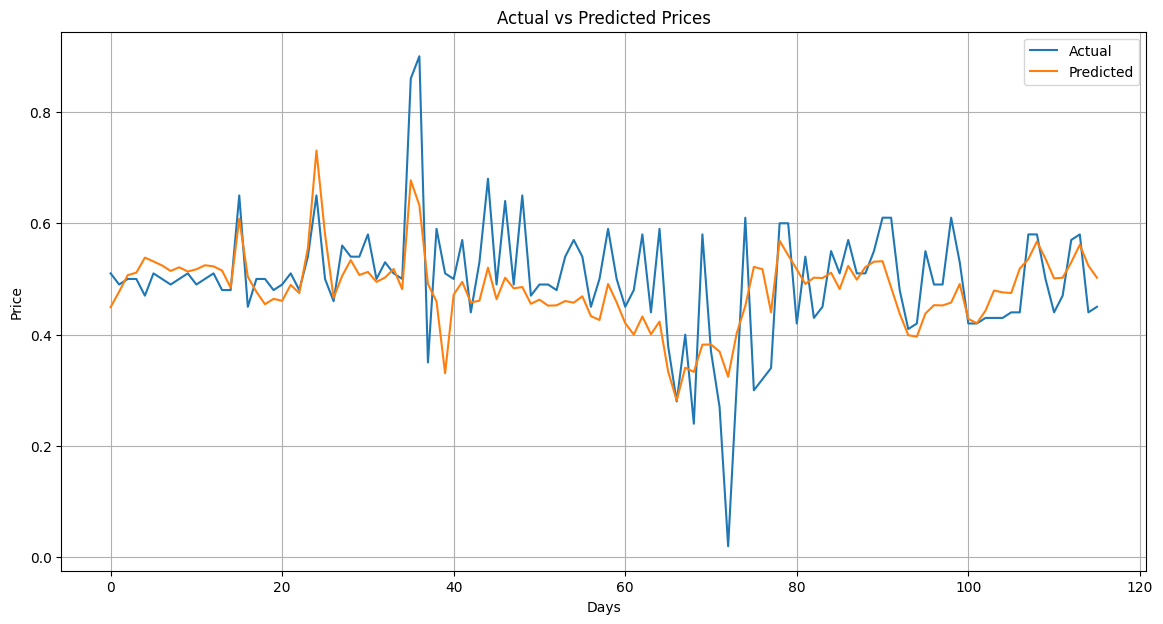

In [83]:
plt.figure(figsize=(14, 7))
plt.plot(y_true, label='Actual')
plt.plot(y_pred, label='Predicted')
plt.title('Actual vs Predicted Prices')
plt.xlabel('Days')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.show()

In [84]:
aubank_data = pd.DataFrame(aubank_data)

In [85]:
old_close = 580.099

In [86]:
predicted_prices = []

In [87]:
for i in range(0, len(y_pred)):
    current_val = y_pred[i]

    if(current_val > 0.5):
        new_value = old_close +  (((current_val - 0.5)*2) * aubank_max_rise) 

    else:
        new_value = old_close -  (((0.5 - current_val)*2) * aubank_max_fall)

    
    predicted_prices.append(new_value)
    old_close = new_value

In [88]:
aubank_data_new = pd.read_csv(f'{folder_path}/AUBANK.NS.csv')

In [89]:
print(aubank_data_new.columns)

aubank_data.head(20)

Index(['Date', 'Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume', 'SMA_9',
       'SMA_21', 'EMA_9', 'EMA_21', 'DEMA_9', 'DEMA_21', 'MACD_Line',
       'MACD_Signal_Line', 'RSI_14', 'Stoch_Oscillator_K',
       'Stoch_Oscillator_D', 'BB_middle', 'BB_upper', 'BB_lower', 'ADX',
       'ADX+DI', 'ADX-DI', 'CMF', 'OBV', 'CCI', 'Williams_%R', 'ATR',
       'Target'],
      dtype='object')


,0
0,60.200012
1,82.075012


In [90]:
# get the close prices for the test data
close_prices = aubank_data_new.loc[test_indices, 'Close'].values

In [91]:
print(close_prices)

[334.0249939  335.79998779 334.70001221 334.67498779 329.67498779
 328.07501221 328.2749939  316.45001221 317.04998779 329.7250061
 328.5249939  327.2749939  339.1499939  328.6000061  334.4750061
 317.32501221 329.45001221 332.1000061  334.5249939  344.875
 342.6000061  347.57501221 348.7250061  350.         347.9750061
 347.0249939  335.79998779 329.875      338.79998779 336.75
 334.7250061  330.67498779 336.8500061  333.42498779 336.75
 337.625      333.54998779 333.57501221 331.29998779 334.4750061
 334.6499939  333.42498779 318.82501221 326.875      322.3999939
 322.25       341.25       334.9750061  322.0249939  327.125
 331.75       329.75       326.95001221 324.92498779 322.2749939
 326.4750061  320.625      319.3500061  326.92498779 321.8500061
 321.7749939  323.7250061  323.92498779 327.20001221 344.625
 347.125      340.875      344.20001221 343.4750061  344.79998779
 344.8999939  342.82501221 344.20001221 343.3999939  337.375
 333.2749939  342.54998779 344.75       359.20001

In [92]:
print(predicted_prices)

[np.float64(571.7690585463332), np.float64(568.0387319588825), np.float64(568.8631496933066), np.float64(570.2222523372528), np.float64(574.8329031916854), np.float64(578.621124174684), np.float64(581.5345419140411), np.float64(583.2696018371333), np.float64(585.7829998258438), np.float64(587.3966494021278), np.float64(589.4820683831184), np.float64(592.447105972611), np.float64(595.1664594846133), np.float64(596.9744962262829), np.float64(594.3883912370492), np.float64(607.4089512331683), np.float64(607.8710181441473), np.float64(604.0781222122877), np.float64(596.6314896582679), np.float64(590.764177802679), np.float64(584.3170403820603), np.float64(582.5754503205297), np.float64(578.4000448468922), np.float64(585.0481189145265), np.float64(612.8166129047221), np.float64(622.4796723106246), np.float64(616.9252365293922), np.float64(617.5920676811492), np.float64(621.6757123747938), np.float64(622.5271707870032), np.float64(624.0470032771171), np.float64(623.1864717713378), np.float64

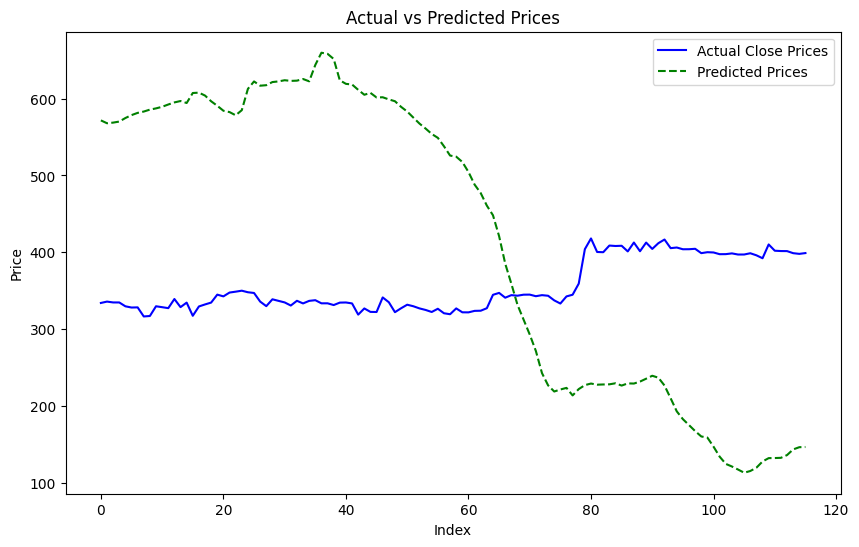

In [102]:
plt.figure(figsize=(10, 6))
plt.plot(close_prices, label='Actual Close Prices', color='blue', linestyle='-')
plt.plot(predicted_prices, label='Predicted Prices', color='green', linestyle='--')

# #delta change in price
# plt.plot(np.abs(np.array(predicted_prices) - np.array(close_prices)), label='Delta Change in Price', color='red', linestyle='-.')

plt.title('Actual vs Predicted Prices')
plt.xlabel('Index')
plt.ylabel('Price')

plt.legend()
plt.show()

In [95]:
print(y_pred)

[0.4492540955543518, 0.47727489471435547, 0.5068473219871521, 0.5112882256507874, 0.5382944345474243, 0.531463623046875, 0.5241978168487549, 0.5144107937812805, 0.5208753943443298, 0.5134024024009705, 0.5173207521438599, 0.5246265530586243, 0.5225859880447388, 0.5150169134140015, 0.4842454791069031, 0.6081441640853882, 0.5038377642631531, 0.47689372301101685, 0.4546352028846741, 0.4642564058303833, 0.4607241153717041, 0.4893902540206909, 0.47456347942352295, 0.5552165508270264, 0.7306352853775024, 0.5802579522132874, 0.46616244316101074, 0.5055384635925293, 0.5339173078536987, 0.5070719122886658, 0.5126231908798218, 0.49475765228271484, 0.5025551915168762, 0.5178385376930237, 0.48162001371383667, 0.677122175693512, 0.6322298049926758, 0.49103158712387085, 0.4594849944114685, 0.3307368755340576, 0.4717918038368225, 0.4948083758354187, 0.45775043964385986, 0.4609523415565491, 0.5202890634536743, 0.46355026960372925, 0.5022934675216675, 0.4830361604690552, 0.4855068325996399, 0.4553803801

In [96]:
print(y_test)

[0.51 0.49 0.5  0.5  0.47 0.51 0.5  0.49 0.5  0.51 0.49 0.5  0.51 0.48
 0.48 0.65 0.45 0.5  0.5  0.48 0.49 0.51 0.48 0.54 0.65 0.5  0.46 0.56
 0.54 0.54 0.58 0.5  0.53 0.51 0.5  0.86 0.9  0.35 0.59 0.51 0.5  0.57
 0.44 0.53 0.68 0.49 0.64 0.49 0.65 0.47 0.49 0.49 0.48 0.54 0.57 0.54
 0.45 0.5  0.59 0.5  0.45 0.48 0.58 0.44 0.59 0.38 0.28 0.4  0.24 0.58
 0.37 0.27 0.02 0.31 0.61 0.3  0.32 0.34 0.6  0.6  0.42 0.54 0.43 0.45
 0.55 0.51 0.57 0.51 0.51 0.55 0.61 0.61 0.48 0.41 0.42 0.55 0.49 0.49
 0.61 0.53 0.42 0.42 0.43 0.43 0.43 0.44 0.44 0.58 0.58 0.5  0.44 0.47
 0.57 0.58 0.44 0.45]
